# Análisis predictivo de series temporales

-----

## Modelos de media móvil

In [1]:
#install.packages("devtools")     # only need to do this once
#devtools::install_github("nickpoison/astsa")
install.packages("astsa")
library(astsa)
options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



### Repaso: procesos autorregresivos

Recordemos primero la definición de proceso autorregresivo (de media 0):

> **Definición:** un proceso $\{x_t\}$ es autorregresivo de orden $p$ si admite la representación
>
> $$ x_t = \phi_1 x_{t-1} + \ldots + \phi_p x_{t-p} + w_t,$$
>
> con $w_t$ ruido blamco de varianza $\sigma_w^2$.

### Autocorrelación y autocorrelación parcial

En un proceso autorregresivo puro:

* La autocorrelación decae de forma exponencial como función del lag.
* La autocorrelación parcial se anula para lags mayores a $p$.

## Proceso de media móvil

> **Definición:** un proceso $\{x_t\}$ es una media móvil de orden $q$ o $MA(q)$ si verifica:
>
> $$ x_t = w_t + \theta_1 w_{t-1} + \ldots + \theta_q w_{t-q},$$
>
> donde hay $q$ lags en la media móvil, $\theta_1,\ldots,\theta_q$ son parámetros, $\theta_q\neq0$ y $\{w_t\}$ es ruido blanco (Gaussiano) de varianza $\sigma^2_w$. 

* Es el proceso dual del AR, donde el valor actual depende de valores pasados del ruido solamente, y no de la propia serie. 
* El ruido blanco puede pensarse como una media móvil de orden $0$.
* Si $q>0$ el proceso es más suave que el ruido puro.

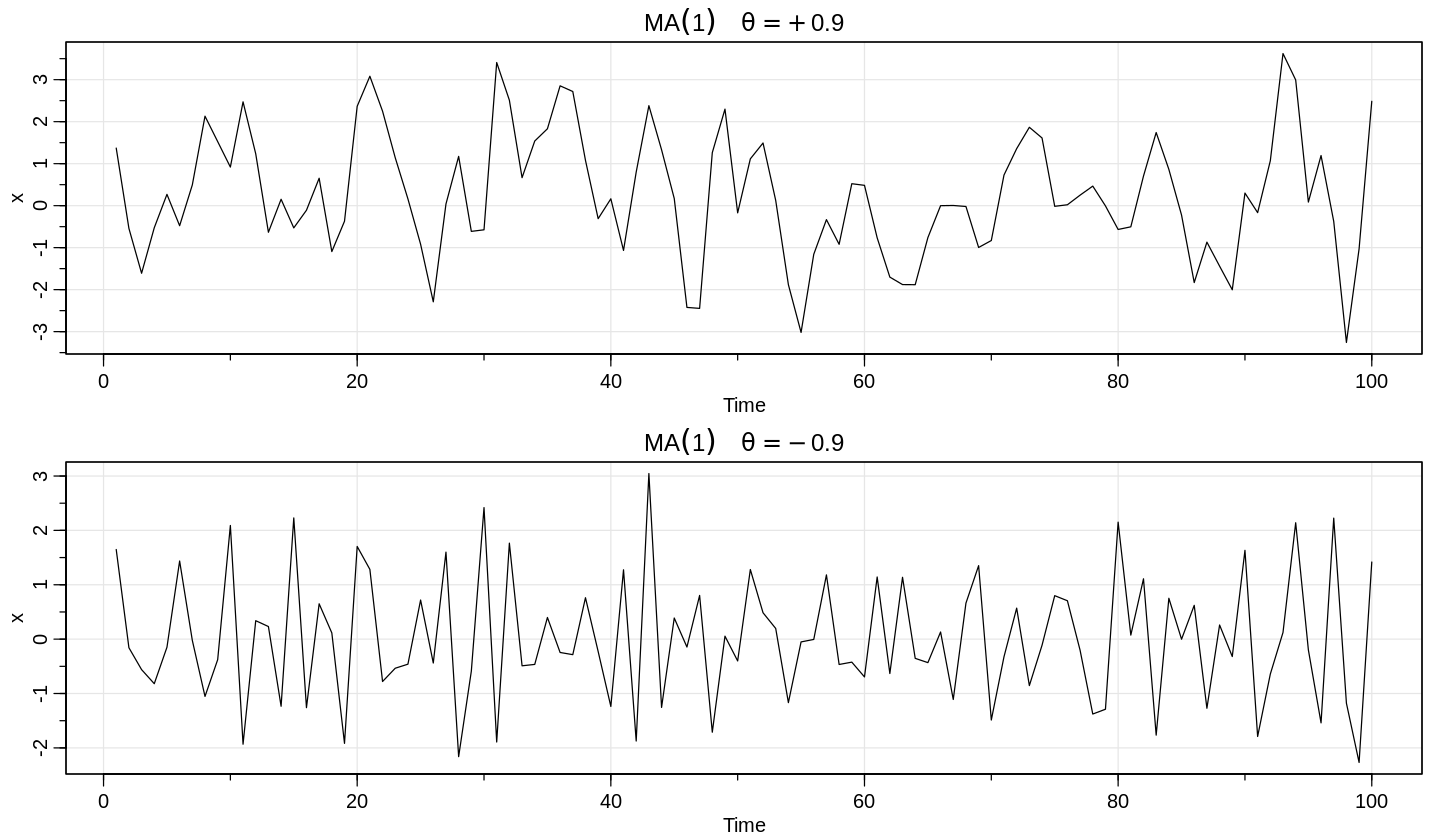

In [2]:
## Ejemplo: media movil de orden 1

par(mfrow=c(2,1))                                   
tsplot(arima.sim(list(order=c(0,0,1), ma=.9), n=100), ylab="x", main=(expression(MA(1)~~~theta==+.9)))    
tsplot(arima.sim(list(order=c(0,0,1), ma=-.9), n=100), ylab="x", main=(expression(MA(1)~~~theta==-.9)))  

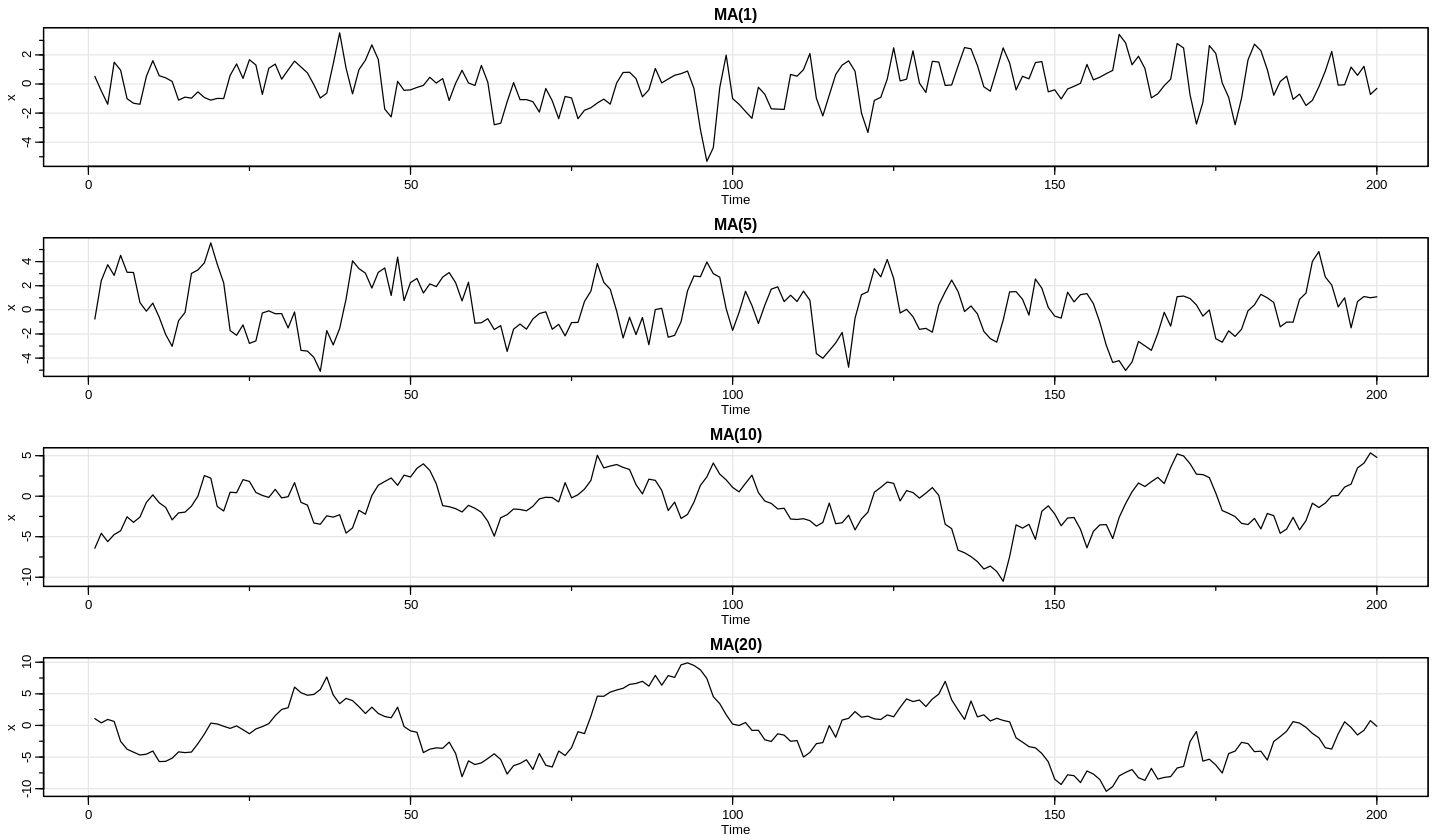

In [3]:
## Ejemplo: media movil de orden variable

par(mfrow=c(4,1))                                   
tsplot(arima.sim(list(order=c(0,0,1), ma=c(1)), n=200), ylab="x", main="MA(1)")
tsplot(arima.sim(list(order=c(0,0,5), ma=rep(1,5)), n=200), ylab="x", main="MA(5)")
tsplot(arima.sim(list(order=c(0,0,10), ma=rep(1,10)), n=200), ylab="x", main="MA(10)")
tsplot(arima.sim(list(order=c(0,0,20), ma=rep(1,20)), n=200), ylab="x", main="MA(20)")

### Ejemplo: media movil de orden 1

El proceso MA(1) está dado por

$$ x_t = w_t + \theta w_{t-1}.$$

**Propiedades**:

* $E[x_t] = E[w_t] + \theta E[w_{t-1}] = 0$.
* $E[x_t^2] = E[w_t^2] +  2\theta E[w_tw_{t-1}] + \theta^2 E[w_{t-1}^2] = (1+\theta^2)\sigma^2_w.$
* $E[x_t x_{t-1}] = E[(w_t + \theta w_{t-1})(w_{t-1} + \theta w_{t-2})] = \theta \sigma^2_w.$
* $E[x_t x_{t-h}] = 0$ si $h>1$ porque los ruidos que participan no están correlacionados.

Resumiendo, la función de autocovarianza de un MA(1) tiene la forma:

$$\gamma_(h) = \left\{\begin{array}{ll}(1+\theta^2)\sigma_w^2 & h=0\\ \theta\sigma_w^2 & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$

La función de autocorrelación es entonces:
$$\rho_(h) = \left\{\begin{array}{ll}1 & h=0\\ \frac{\theta}{1+\theta^2} & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$


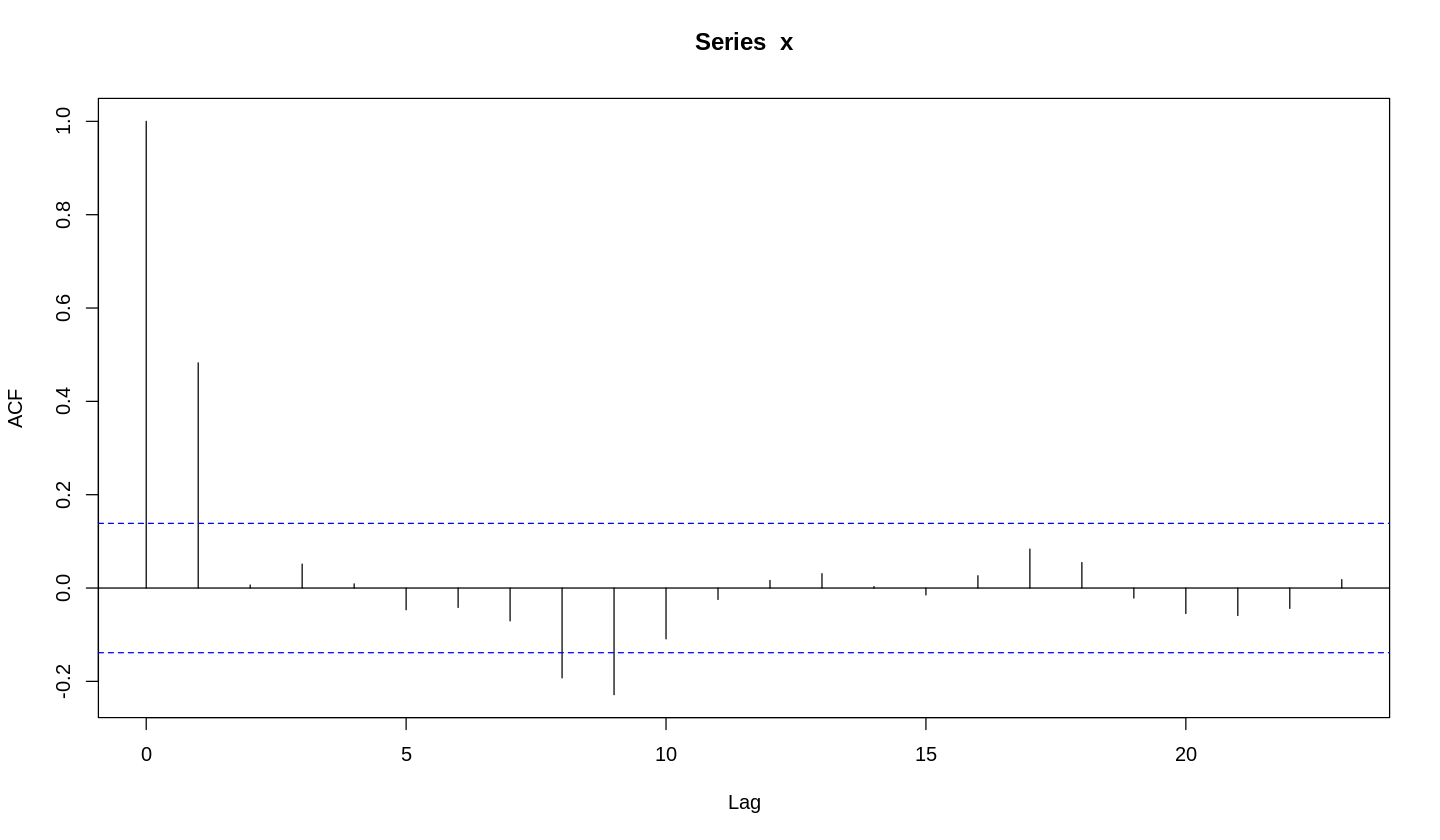

In [4]:
x=arima.sim(list(order=c(0,0,1), ma=c(1)), n=200)

acf(x)

La propiedad anterior es general, es decir, si $x_t$ es un proceso $MA(q)$ entonces la ACF de $x_t$ es $0$ para lags $h>q$.

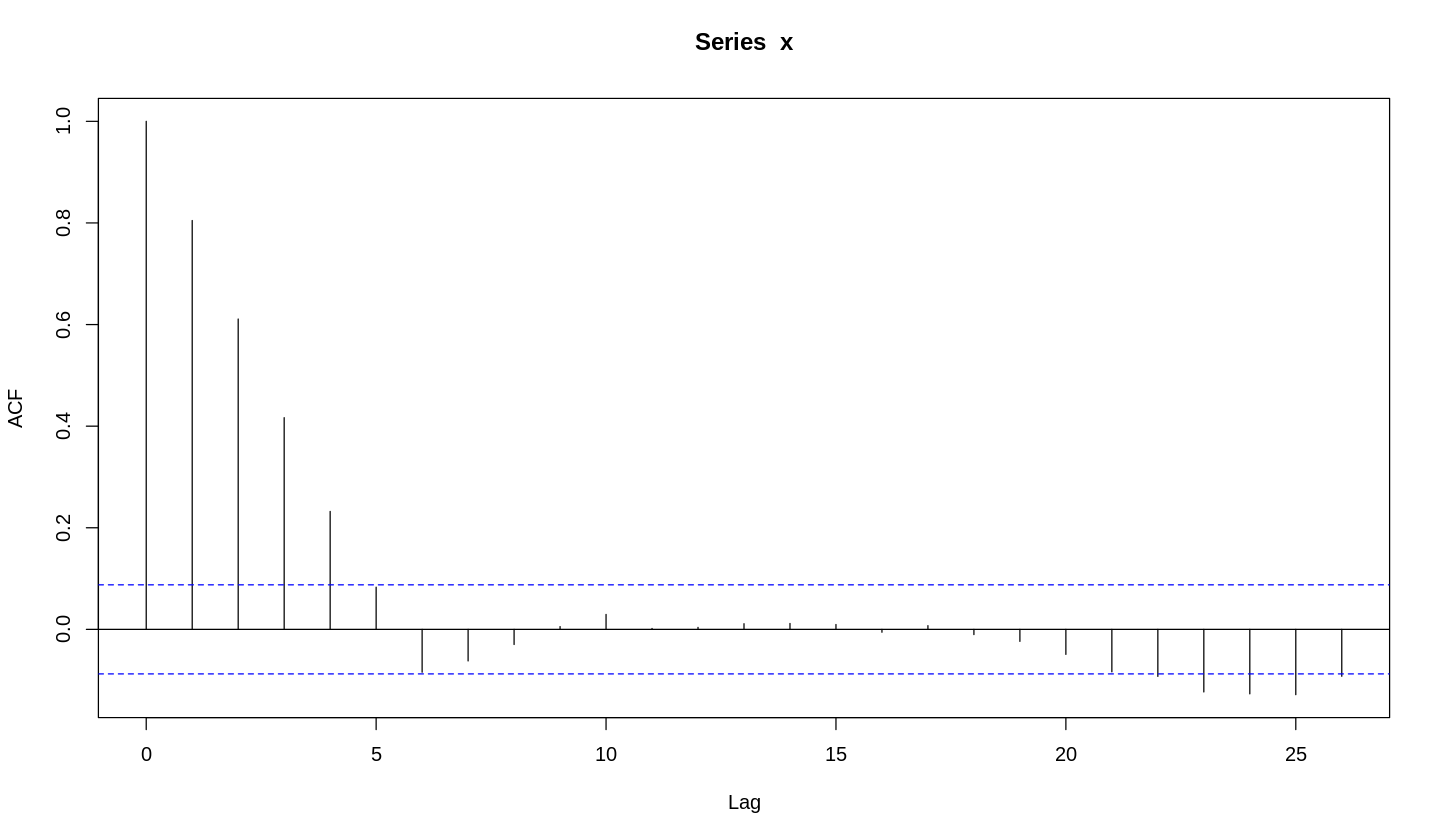

In [5]:
x=arima.sim(list(order=c(0,0,5), ma=rep(1,5)), n=500)

acf(x)

En cambio, la PACF no tiene el mismo comportamiento:

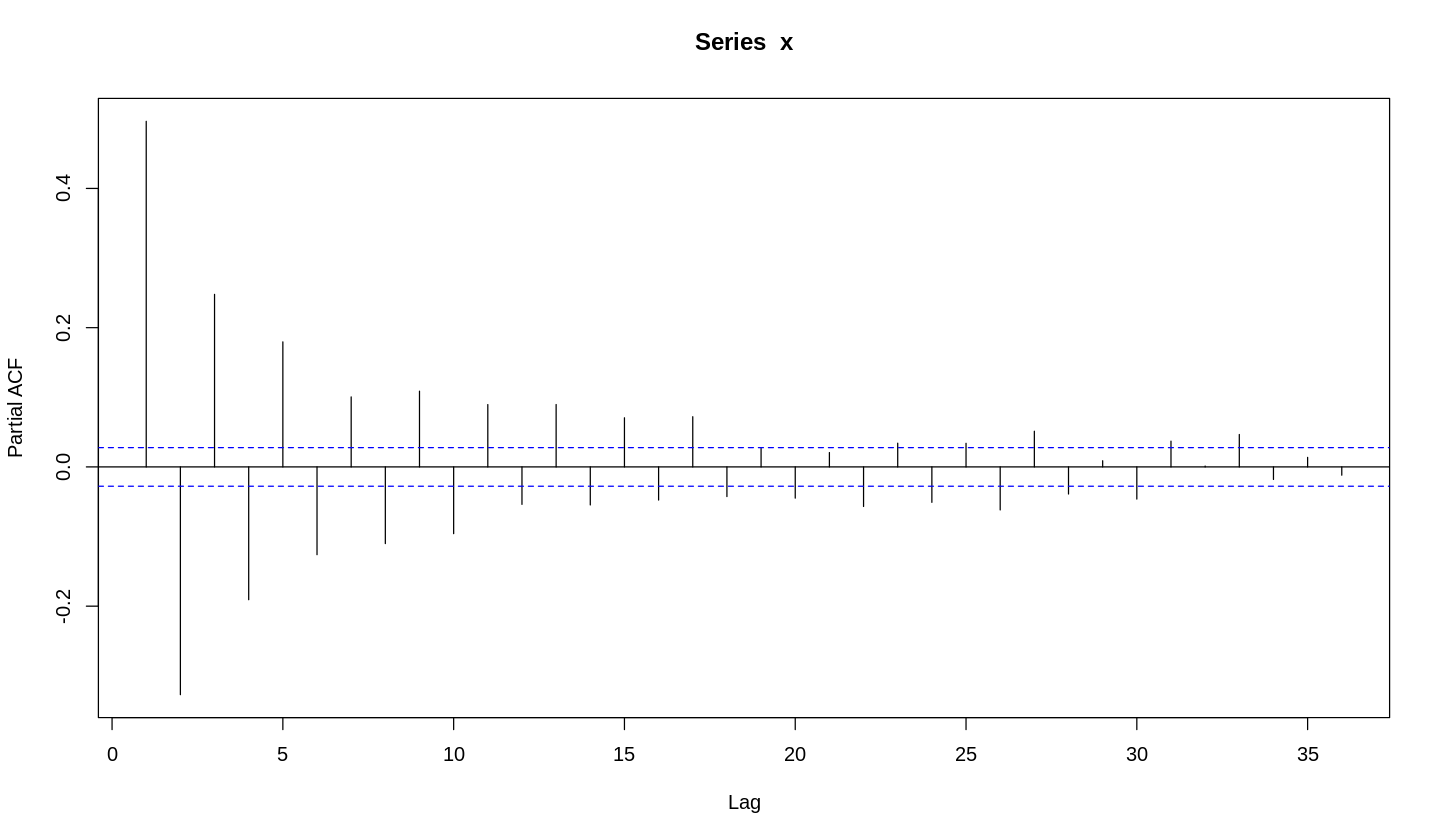

In [6]:
x=arima.sim(list(order=c(0,0,1), ma=c(1)), n=5000)

pacf(x)

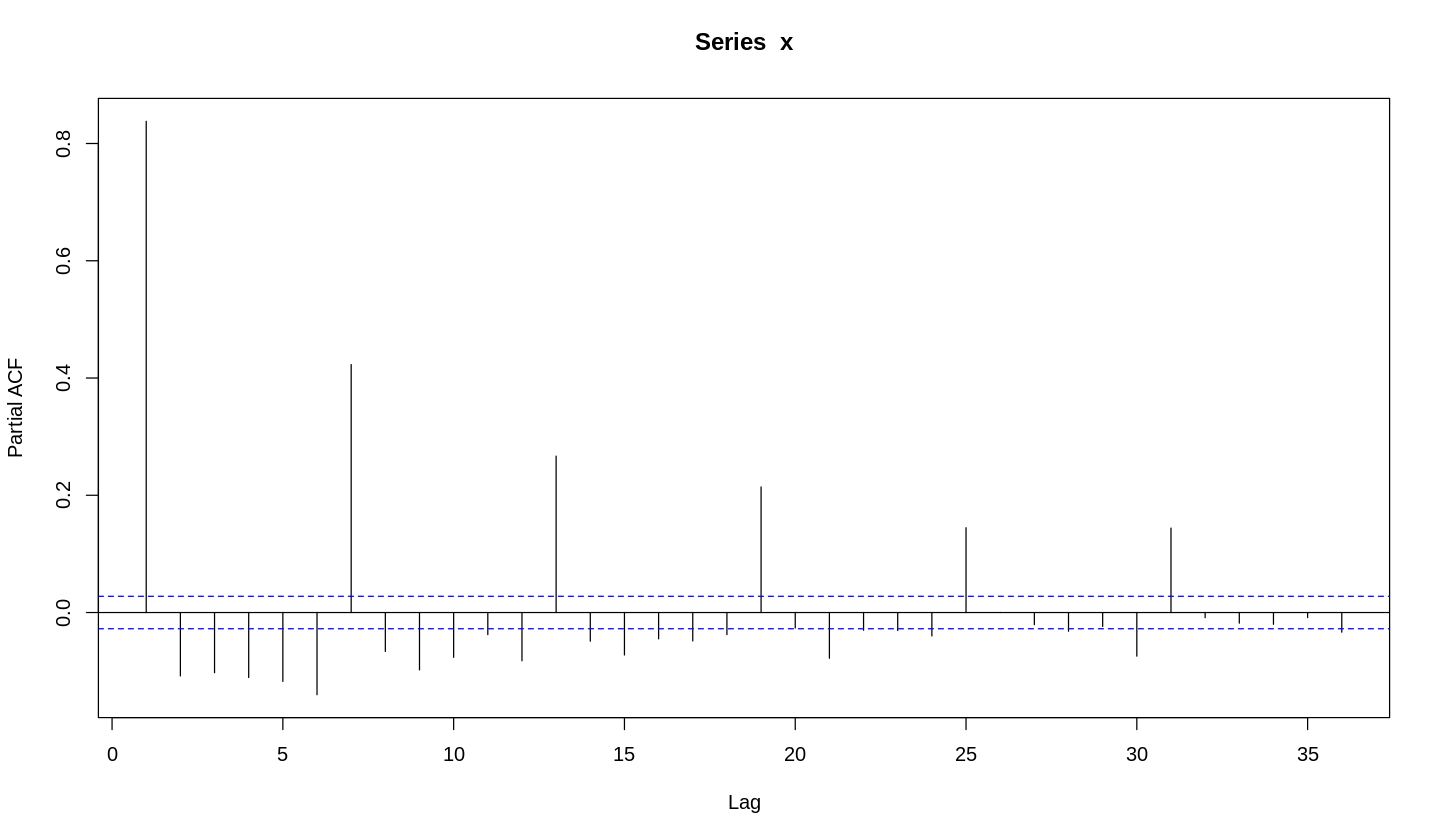

In [7]:
x=arima.sim(list(order=c(0,0,5), ma=rep(1,5)), n=5000)

pacf(x)

### Resumen:

En el proceso $MA(q)$ :

* La función de autocorrelación tiene $q$ lags activos.
* La función de autocorrelación parcial decae lentamente

Es decir, a la inversa de lo que ocurre en AR.

### Ajuste de un proceso $MA(q)$

Comencemos por el $MA(1)$ dado por:

$$x_t = w_t + \theta w_{t-1}.$$

El proceso $w_t$ no es directamente observable, entonces no podemos hacer una regresión a sus valores anteriores. Deberíamos "despejar" $w_t$ de algún modo.

Observemos la siguiente recursión:

$$ \left.\begin{array}{c}
    x_t = w_t + \theta w_{t-1} \\
    x_{t-1} = w_{t-1} + \theta w_{t-2}\end{array}\right\} \Rightarrow x_t = w_t + \theta x_{t-1} -\theta^2 w_{t-2}$$
    
Siguiendo la recursión, si $|\theta|<1$ el modelo se dice *invertible* y podemos escribir:

$$ x_{t} = \sum_{j=1}^\infty (-\theta)^j x_{t-j} +w_t$$

es decir, convertimos un $MA(1)$ en un $AR(\infty)$ en cierto modo. Como $\theta^j$ es decreciente, podríamos hacer una regresión y tratar de adivinar $\theta$.

**Problema**: Es no lineal en $\theta$ lo que estamos buscando.

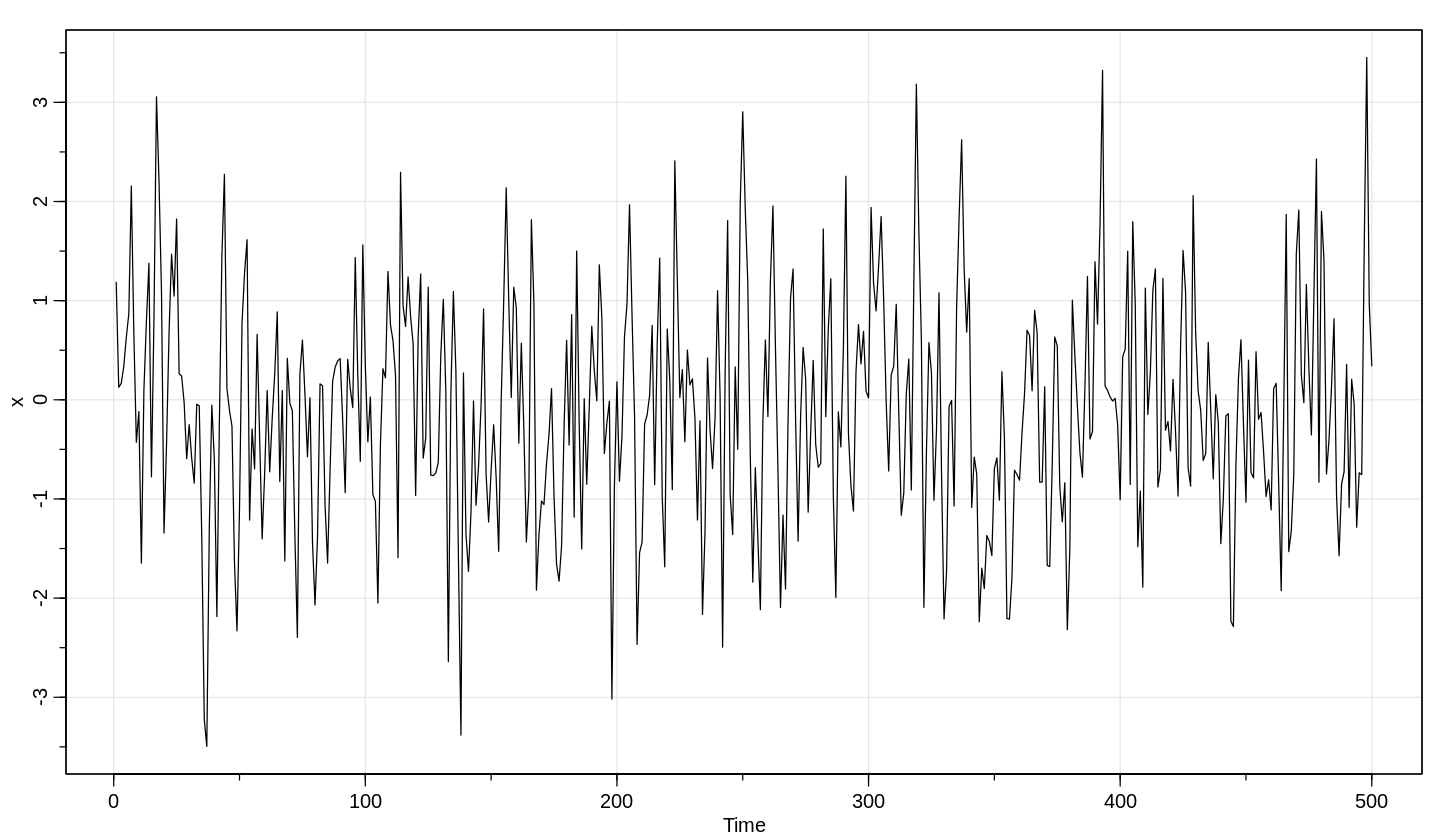

In [8]:
## Ejemplo: simulo un MA(1) con theta = 0.5 y hago varios fits

x=arima.sim(list(order=c(0,0,1), ma=0.5), n=500)
x=ts(x)
tsplot(x)


In [9]:
n_series = ts.intersect(x,x1=lag(x,-1))

fit <- lm(x~0+x1,data=n_series)
summary(fit)


Call:
lm(formula = x ~ 0 + x1, data = n_series)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.01280 -0.75909 -0.07287  0.62548  2.92774 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
x1  0.39788    0.04106    9.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.036 on 498 degrees of freedom
Multiple R-squared:  0.1586,	Adjusted R-squared:  0.1569 
F-statistic: 93.89 on 1 and 498 DF,  p-value: < 2.2e-16


In [10]:
n_series = ts.intersect(x,x1=lag(x,-1),x2=lag(x,-2))

fit <- lm(x~0+x1+x2,data=n_series)
summary(fit)


Call:
lm(formula = x ~ 0 + x1 + x2, data = n_series)

Residuals:
     Min       1Q   Median       3Q      Max 
-3.04807 -0.76869 -0.09315  0.57127  3.06455 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
x1  0.45989    0.04436  10.367  < 2e-16 ***
x2 -0.15407    0.04434  -3.475 0.000556 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.025 on 496 degrees of freedom
Multiple R-squared:  0.1788,	Adjusted R-squared:  0.1755 
F-statistic: 53.99 on 2 and 496 DF,  p-value: < 2.2e-16


In [11]:
n_series = ts.intersect(x,x1=lag(x,-1),x2=lag(x,-2),x3=lag(x,-3))

fit <- lm(x~0+x1+x2+x3,data=n_series)
summary(fit)


Call:
lm(formula = x ~ 0 + x1 + x2 + x3, data = n_series)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.99438 -0.71284 -0.06774  0.59331  3.03554 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
x1  0.47901    0.04466  10.726  < 2e-16 ***
x2 -0.21065    0.04867  -4.328 1.82e-05 ***
x3  0.12299    0.04504   2.731  0.00654 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.019 on 494 degrees of freedom
Multiple R-squared:  0.1911,	Adjusted R-squared:  0.1862 
F-statistic:  38.9 on 3 and 494 DF,  p-value: < 2.2e-16


**Problema:** el procedimiento anterior no es muy práctico, y si quisiéramos hacer regresión no lineal necesitamos un buen estimador inicial de $\theta$. Además no generaliza bien a $q$.

**Método de los momentos:** es otra idea válida, recordemos la función de autocorrelación del $MA(1)$.


$$\rho(h) = \left\{\begin{array}{ll}1 & h=0\\ \frac{\theta}{1+\theta^2} & h=\pm 1 \\ 0 & \text{en otro caso}\end{array}\right.$$

Si estimamos la correlación de orden uno de los datos (es decir la `acf(x)` en el lag $1$) podemos plantear:

$$\hat{\rho} (1) = \hat{\rho} = \frac{\theta}{1+\theta^2},$$

y despejar $\theta$:
$$\hat{\rho} \theta^2 - \theta + \hat{\rho} = 0.$$

Es decir:
$$\theta = \frac{1 \pm \sqrt{1-4\hat{\rho}^2}}{2 \hat{\rho}}.$$

**Observación**: dos soluciones!! ¿Cuál elijo? ¿Y además qué pasa si da complejo?

* Se elije la "invertible", es decir aquella que da menor a $1$.
* En teoría $\rho(1)<0.5$ si $\theta<1$ entonces no puede dar complejo. Pero al estimar $\rho$ por $\hat{\rho}$ puede ocurrir.
* Para estimar $\sigma^2_w$, la varianza del ruido, podemos usar que $\sigma^2_x = (1+\theta^2)\sigma^2_w$ y usar el valor de $\theta$ estimado.

In [12]:
#### Ejemplo

rho=acf(x,1,plot=F)
r=rho$acf[2]

theta = (1-sqrt(1-4*r^2))/(2*r)
theta

[1] 0.4840627

In [13]:
# Estimo la varianza del ruido por método de los momentos despejando (debería dar 1 en este caso).

var(x)/(1+theta^2)

[1] 1.023613

* El método de los momentos se puede generalizar a mayor orden, y también se puede utilizar en el caso $AR(p)$ (donde se denominan Ecuaciones de Yule-Walker). 

* Sin embargo, en la práctica, estos estimadores no son los más eficientes. En general, si los ruidos son gaussianos, conviene usar un enfoque de *máxima verosimilitud*. Este es el método que utiliza R.

* Discutiremos más este método en relación al modelo completo ARMA.


In [14]:
# Ejemplo

fit = arima(x,order = c(0,0,1), include.mean=F)
fit


Call:
arima(x = x, order = c(0, 0, 1), include.mean = F)

Coefficients:
         ma1
      0.4853
s.e.  0.0403

sigma^2 estimated as 1.03:  log likelihood = -717.1,  aic = 1438.21

## Ejercicio

Analizar la serie de grosor glacial del paquete `astsa` (serie `varve`). Aplicar la transformación `diff(log(x))` para obtener una serie estacionaria y discutir el ajuste de un modelo $MA(q)$. 

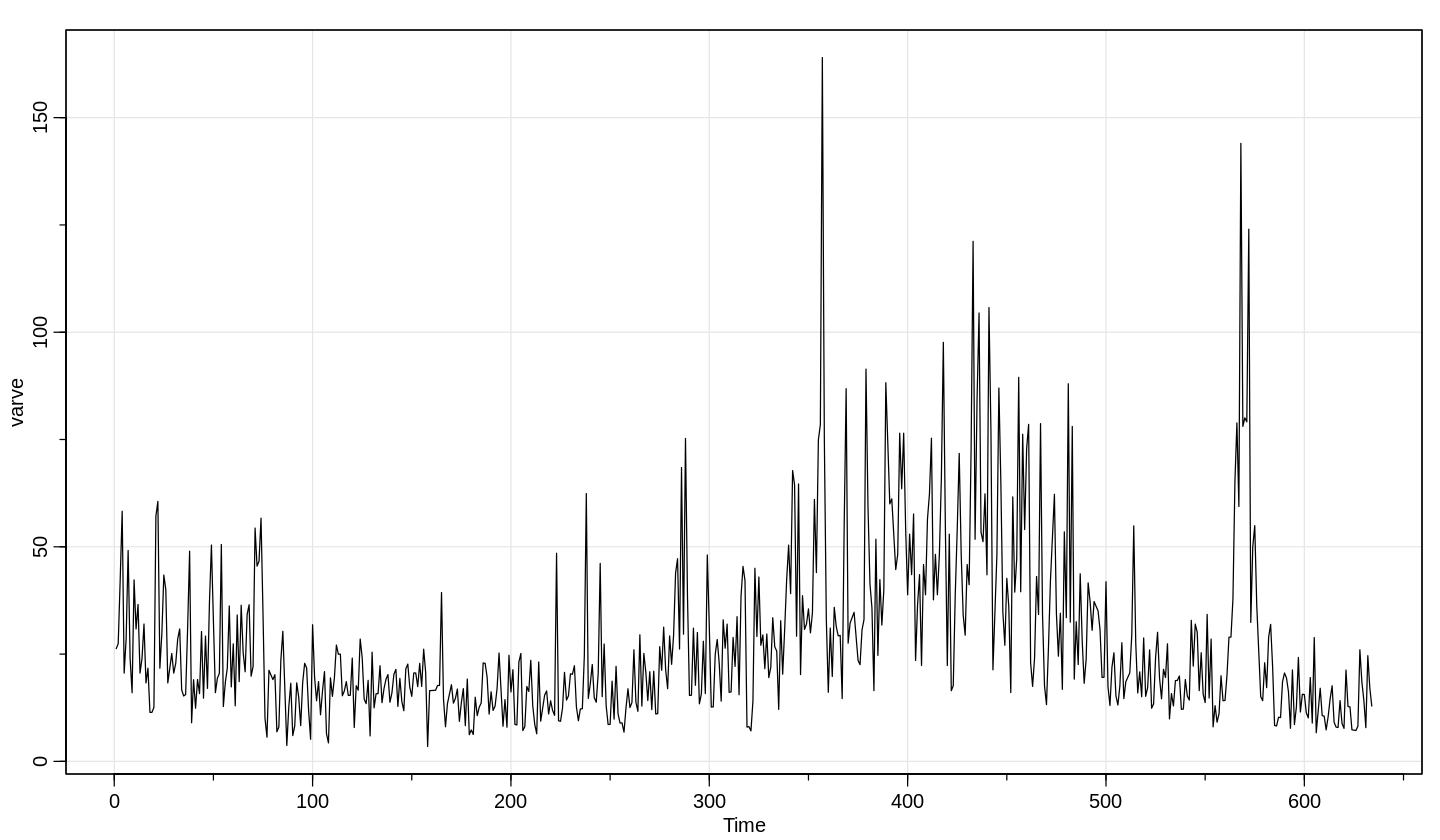

In [15]:
tsplot(varve)